# Models for Win / Loose determination based on one player's data

## Import MatPlotLib & Setup

In [8]:
# Setup plotting
import matplotlib.pyplot as plt
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

## Import Keras, Pandas & other used libraries

In [9]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import pandas as pd
import time

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

import xgboost as xgb


## Import Data

In [11]:
df_game_players_processed_features = pd.read_csv("../data/processed/game_players_processed_features.csv")

df_game_players_processed_features_columns = df_game_players_processed_features.columns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_game_players_processed_features.head()

,game_id,player_id,player_name,team_id,team_name,game_length,role,champion_name,win,KLA,gold_pm,lvl_pm,creep_score_pm,wards_pm,damage_pm,damage_to_champions_pm,damage_taken_pm,greatest_killing_spree,greatest_multi_kill
0,15,0,shanji,0,Legend Esport Gaming,1415,Top,Irelia,False,0.500000,6.028269,0.008481,0.126502,0.005654,69.969611,5.599293,10.831095,0,1
1,15,1,Demon,1,Bilibili Gaming Junior,1415,Top,Vladimir,True,2.000000,6.053004,0.009894,0.122968,0.007774,70.913074,7.672792,11.643110,2,1
2,15,2,yanxuan,0,Legend Esport Gaming,1415,Bot,Kai'Sa,False,1.000000,6.793640,0.008481,0.160424,0.006360,82.266431,4.954770,4.090459,0,1
3,15,4,HanXuan,1,Bilibili Gaming Junior,1415,Mid,Aatrox,True,2.666667,7.155477,0.009894,0.132862,0.007067,88.354770,7.596466,10.940636,3,2
4,15,5,Yui,1,Bilibili Gaming Junior,1415,Support,Alistar,True,6.000000,5.381625,0.008481,0.031802,0.017668,19.315901,2.041696,5.878445,0,1


## Preprocessing data for win determination with one player's data

In [12]:
def get_useful_players_data(dataframe : pd.DataFrame) -> pd.DataFrame:
    new_df = pd.DataFrame()
    
    new_df = dataframe[useful_player_columns_num]
    
    return new_df

def get_solo_player_data(player_id : int, game_id : int) -> pd.DataFrame:
    """
    Get player data for a specific player and game.
    """
    # Filter by game_id first
    df_player = df_game_players_processed_features[df_game_players_processed_features['game_id'] == game_id]
    
    # Filter by player_id
    df_player = df_player[df_player['player_id'] == player_id]
    
    df_player_selected = get_useful_players_data(df_player)
    
    return df_player_selected

useful_player_columns_num = ['KLA', 'gold_pm', 'lvl_pm', 'creep_score_pm', 'wards_pm',
                            'damage_pm', 'damage_to_champions_pm', 'damage_taken_pm',
                            'greatest_killing_spree', 'greatest_multi_kill']

win_loose_preprocessor = make_column_transformer((MinMaxScaler(), useful_player_columns_num))

player_roles = ['Top', 'Jungle', 'Mid', 'Support', 'Bot']


def group_train_val_test_split(X, y, groups, train_size=0.75, val_size=0.15, test_size=0.10):
    """Split data into training, validation and test sets preserving group structure."""
    # First split: separate train from (val+test)
    splitter1 = GroupShuffleSplit(n_splits=1, train_size=train_size)
    train_idx, temp_idx = next(splitter1.split(X, y, groups=groups))
    
    # Get corresponding groups for the temp indices
    temp_groups = groups.iloc[temp_idx]
    
    # Calculate validation proportion from the remaining data
    val_proportion = val_size / (1 - train_size)
    
    # Second split: divide (val+test) into validation and test
    splitter2 = GroupShuffleSplit(n_splits=1, train_size=val_proportion)
    val_idx_temp, test_idx_temp = next(splitter2.split(
        X.iloc[temp_idx], y.iloc[temp_idx], groups=temp_groups))
    
    # Convert relative indices back to original indices
    val_idx = temp_idx[val_idx_temp]
    test_idx = temp_idx[test_idx_temp]
    
    return X.iloc[train_idx], X.iloc[val_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[val_idx], y.iloc[test_idx]

def get_role_data(role: str, test_game_id: int | None = None) -> tuple:
        
    X = df_game_players_processed_features.loc[df_game_players_processed_features['role'] == role].copy()
    
    if test_game_id is not None:
        X = X.loc[X['game_id'] != test_game_id].copy()
    
    y = X['win'].copy()
    group = X['game_id'].copy()
    
    X = get_useful_players_data(X)
    
    X_train, X_valid, X_test, y_train, y_valid, y_test = group_train_val_test_split(X, y, group)
    
    X_train = win_loose_preprocessor.fit_transform(X_train)
    X_valid = win_loose_preprocessor.transform(X_valid)
    X_test = win_loose_preprocessor.transform(X_test)
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test

## Visualize size of training & validations datasets

Dataset sizes per role:


,Role,Training Samples,Validation Samples,Total Samples,Train %
0,Top,55454.0,11128.0,66582.0,83.3
1,Jungle,55400.0,11066.0,66466.0,83.4
2,Mid,55422.0,11091.0,66513.0,83.3
3,Support,55497.0,11077.0,66574.0,83.4
4,Bot,55576.0,11106.0,66682.0,83.3


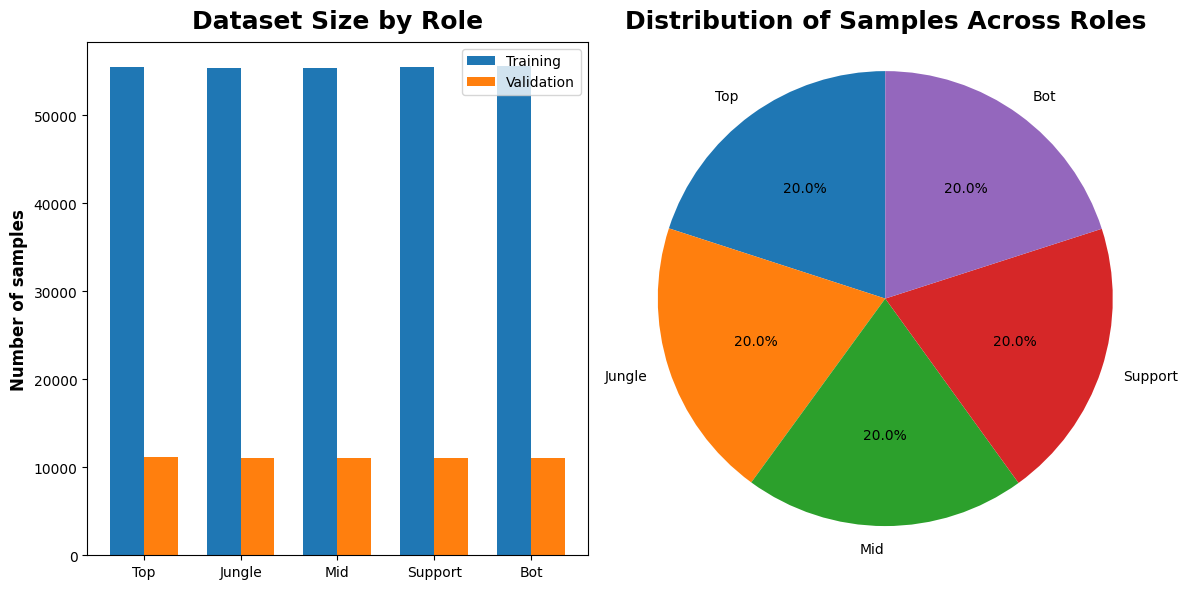

In [13]:
# Calculate and display dataset sizes for each role
def calculate_dataset_sizes():
    # Dictionary to store all dataset sizes
    dataset_sizes = {}
    
    # Get sizes for each role
    for role in player_roles:
        X_train, X_valid, X_test, y_train, y_valid, y_test = get_role_data(role)
        
        dataset_sizes[role] = {
            'train': len(X_train),
            'valid': len(X_valid),
            'total': len(X_train) + len(X_valid)
        }
    
    return dataset_sizes

# Get dataset sizes
dataset_sizes = calculate_dataset_sizes()

# Create a dataframe for better visualization
size_df = pd.DataFrame({
    'Role': [],
    'Training Samples': [],
    'Validation Samples': [],
    'Total Samples': [],
    'Train %': []
})

for role, sizes in dataset_sizes.items():
    size_df = pd.concat([size_df, pd.DataFrame({
        'Role': [role],
        'Training Samples': [sizes['train']],
        'Validation Samples': [sizes['valid']],
        'Total Samples': [sizes['total']],
        'Train %': [round(sizes['train'] / sizes['total'] * 100, 1)]
    })], ignore_index=True)

# Display the dataframe
print("Dataset sizes per role:")
display(size_df)

# Create a visualization
plt.figure(figsize=(12, 6))

# Bar chart of dataset sizes
ax1 = plt.subplot(1, 2, 1)
x = range(len(player_roles))
width = 0.35
ax1.bar([i - width/2 for i in x], 
       [dataset_sizes[role]['train'] for role in player_roles], 
       width, label='Training')
ax1.bar([i + width/2 for i in x], 
       [dataset_sizes[role]['valid'] for role in player_roles], 
       width, label='Validation')
ax1.set_xticks(x)
ax1.set_xticklabels(player_roles)
ax1.set_ylabel('Number of samples')
ax1.set_title('Dataset Size by Role')
ax1.legend()

# Pie chart of total dataset distribution
ax2 = plt.subplot(1, 2, 2)
ax2.pie([dataset_sizes[role]['total'] for role in player_roles],
       labels=player_roles,
       autopct='%1.1f%%',
       startangle=90)
ax2.axis('equal')
ax2.set_title('Distribution of Samples Across Roles')

plt.tight_layout()
plt.show()

## Visualize Activation functions

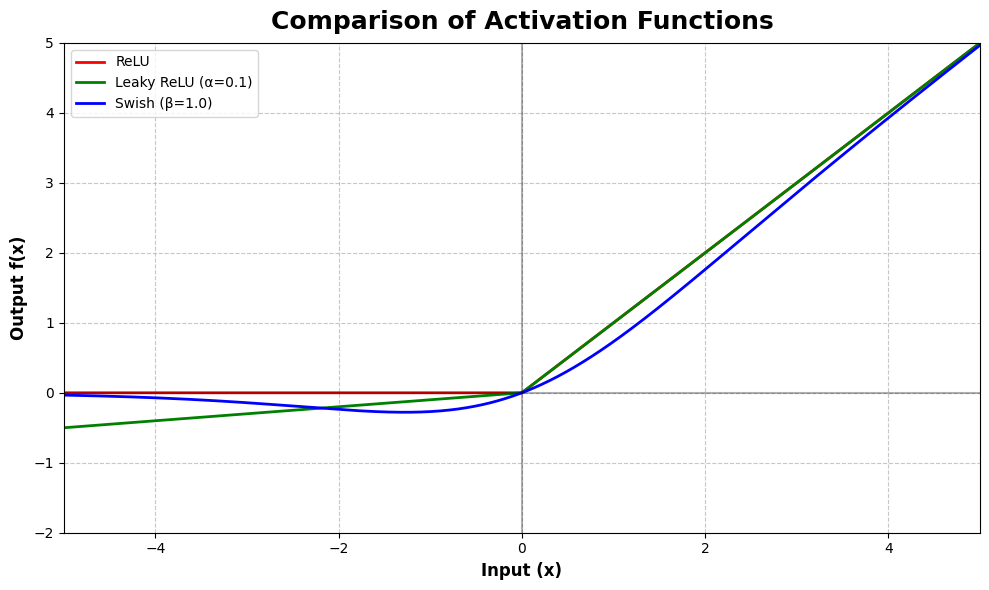

In [14]:
import numpy as np
import tensorflow as tf

def relu(x):
    return np.maximum(0, x)

def leaky_relu(x, alpha=0.1):
    return np.maximum(alpha * x, x)

def swish(x, beta=1.0):
    return x * tf.nn.sigmoid(beta * x)

# Generate x values
x = np.linspace(-5, 5, 1000)

# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the activation functions
ax.plot(x, relu(x), 'r-', linewidth=2, label='ReLU')
ax.plot(x, leaky_relu(x, 0.1), 'g-', linewidth=2, label='Leaky ReLU (α=0.1)')
ax.plot(x, swish(x, 1.0), 'b-', linewidth=2, label='Swish (β=1.0)')

# Add grid and style
ax.grid(True, linestyle='--', alpha=0.7)
ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax.axvline(x=0, color='k', linestyle='-', alpha=0.3)

# Add labels and title
ax.set_xlabel('Input (x)')
ax.set_ylabel('Output f(x)')
ax.set_title('Comparison of Activation Functions')
ax.legend(loc='best')

# Set limits
ax.set_xlim(-5, 5)
ax.set_ylim(-2, 5)

plt.show()

## Create the model

In [15]:
def get_models(input_shape: int, random_state = 42) -> keras.Model:
    tree_model = DecisionTreeClassifier(
        max_depth=5,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        random_state=random_state
    )
    
    xgb_model = xgb.XGBClassifier(
        max_depth=5,
        n_estimators=100,
        learning_rate=0.1,
        random_state=random_state,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    
    sequential_model_1 = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[input_shape]),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid')   
    ])
    
    sequential_model_2 = keras.Sequential([
        layers.Dense(64, input_shape=[input_shape]),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(32),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(16),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(1, activation='sigmoid')
    ])
    
    sequential_model_3 = keras.Sequential([
        layers.Dense(64, input_shape=[input_shape]),
        layers.Activation('swish'),
        layers.Dense(32),
        layers.Activation('swish'),
        layers.Dense(16),
        layers.Activation('swish'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    sequential_model_1.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['binary_accuracy'],
    )
    
    sequential_model_2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['binary_accuracy'],
    )
    
    sequential_model_3.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['binary_accuracy'],
    )
    
    return {
        'tree': tree_model,
        'xgboost': xgb_model,
        'sequential': {'1': sequential_model_1,'2': sequential_model_2,'3': sequential_model_3  }
    }

def train_models(X_train, X_valid, y_train, y_valid, models, epochs=10, batch_size=128):
    results = {}
    
    # Train decision tree
    models["tree"].fit(X_train, y_train)
    tree_train_score = models["tree"].score(X_train, y_train)
    tree_valid_score = models["tree"].score(X_valid, y_valid)
    results["tree"] = {"train_accuracy": tree_train_score, "valid_accuracy": tree_valid_score}
    
    # Train XGBoost
    models["xgboost"].fit(X_train, y_train, 
                         eval_set=[(X_valid, y_valid)],
                         verbose=False)
    xgb_train_score = models["xgboost"].score(X_train, y_train)
    xgb_valid_score = models["xgboost"].score(X_valid, y_valid)
    results["xgboost"] = {"train_accuracy": xgb_train_score, "valid_accuracy": xgb_valid_score}
    
    # Train sequential model
    early_stopping = keras.callbacks.EarlyStopping(
        patience=10,
        min_delta=0.001,
        restore_best_weights=True,
    )
    
    histories = {}
    for key, model in models["sequential"].items():
        histories[key] = model.fit(
            X_train, y_train, 
            validation_data=(X_valid, y_valid), 
            epochs=epochs, 
            batch_size=batch_size, 
            callbacks=[early_stopping],
            verbose=0
        )
    
    # Get the sequential model's performance
    seq_train_scores = {}
    seq_valid_scores = {}
    best_seq_valid = 0
    best_seq_key = None
    
    for key, model in models["sequential"].items():
        seq_train_scores[key] = model.evaluate(X_train, y_train, verbose=0)[1]
        seq_valid_scores[key] = model.evaluate(X_valid, y_valid, verbose=0)[1]
        
        # Track the best sequential model
        if seq_valid_scores[key] > best_seq_valid:
            best_seq_valid = seq_valid_scores[key]
            best_seq_key = key
    
    # Store all sequential results
    results["sequential"] = {
        "train_accuracy": seq_train_scores, 
        "valid_accuracy": seq_valid_scores,
        "histories": histories,
        "best_key": best_seq_key,
        "best_valid_accuracy": best_seq_valid  # Add the best valid accuracy for comparison
    }
    
    # Determine best model based on validation accuracy
    max_valid = 0
    best_model_type = None
    
    # Compare tree
    if results["tree"]["valid_accuracy"] > max_valid:
        max_valid = results["tree"]["valid_accuracy"]
        best_model_type = "tree"
        best_model_instance = models["tree"]
    
    # Compare XGBoost
    if results["xgboost"]["valid_accuracy"] > max_valid:
        max_valid = results["xgboost"]["valid_accuracy"]
        best_model_type = "xgboost"
        best_model_instance = models["xgboost"]
    
    # Compare with best sequential
    if best_seq_valid > max_valid:
        best_model_type = "sequential"
        best_model_instance = models["sequential"][best_seq_key]
    
    return models, results, best_model_type, best_model_instance, best_seq_key

## Visualize model training results

In [16]:
def visualize_model_results(results, best_model_type, best_seq_key=None):
    """
    Visualize model results with comparison charts and history plots.
    
    Parameters:
    - results: Dictionary containing results from all models
    - best_model_type: String indicating the best model type (tree, xgboost, or sequential)
    - best_seq_key: String key of the best sequential model (if applicable)
    
    Returns:
    - fig: The created matplotlib figure
    """
    # Print results
    print(f"Results:")
    print(f"  tree: train acc={results['tree']['train_accuracy']:.4f}, valid acc={results['tree']['valid_accuracy']:.4f}")
    print(f"  xgboost: train acc={results['xgboost']['train_accuracy']:.4f}, valid acc={results['xgboost']['valid_accuracy']:.4f}")
    print(f"  sequential models:")
    for key, score in results['sequential']['train_accuracy'].items():
        valid_score = results['sequential']['valid_accuracy'][key]
        print(f"    model {key}: train acc={score:.4f}, valid acc={valid_score:.4f}")
    
    if best_model_type == "sequential" and best_seq_key is not None:
        print(f"Best model: {best_model_type} - {best_seq_key}")
    else:
        print(f"Best model: {best_model_type}")

    # Create visualization
    fig = plt.figure(figsize=(18, 10))

    # Create a grid layout
    gs = fig.add_gridspec(2, 3)

    # Bar chart for all models comparison (spans top row)
    ax1 = fig.add_subplot(gs[0, :])

    # Prepare data for bar chart
    model_names = ['tree', 'xgboost']
    train_acc = [results['tree']['train_accuracy'], results['xgboost']['train_accuracy']]
    valid_acc = [results['tree']['valid_accuracy'], results['xgboost']['valid_accuracy']]

    # Add each sequential model to the comparison
    for key in results['sequential']['train_accuracy'].keys():
        model_names.append(f'seq-{key}')
        train_acc.append(results['sequential']['train_accuracy'][key])
        valid_acc.append(results['sequential']['valid_accuracy'][key])

    # Plot bar chart
    x = range(len(model_names))
    width = 0.35
    ax1.bar([i - width/2 for i in x], train_acc, width, label='Train')
    ax1.bar([i + width/2 for i in x], valid_acc, width, label='Valid')
    ax1.set_title('Model Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names)
    ax1.set_ylim(0, 1)
    ax1.legend()

    # Add subplots for each sequential model's history
    if 'histories' in results['sequential']:
        histories = results['sequential']['histories']
        
        # Plot loss for all sequential models
        ax2 = fig.add_subplot(gs[1, 0])
        ax2.set_title('Sequential Models - Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        
        # Plot accuracy for all sequential models
        ax3 = fig.add_subplot(gs[1, 1])
        ax3.set_title('Sequential Models - Training Accuracy')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Accuracy')
        
        # Plot validation accuracy for all sequential models
        ax4 = fig.add_subplot(gs[1, 2])
        ax4.set_title('Sequential Models - Validation Accuracy')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Accuracy')
        
        # Plot each model's history with different colors
        colors = ['blue', 'green', 'red']
        for i, (key, history) in enumerate(histories.items()):
            color = colors[i % len(colors)]
            epochs = range(1, len(history.history['loss'])+1)
            
            # Loss plot
            ax2.plot(epochs, history.history['loss'], f'-', color=color, label=f'Train-{key}')
            ax2.plot(epochs, history.history['val_loss'], f'--', color=color, label=f'Valid-{key}')
            
            # Training accuracy plot
            ax3.plot(epochs, history.history['binary_accuracy'], f'-', color=color, label=f'Model-{key}')
            
            # Validation accuracy plot
            ax4.plot(epochs, history.history['val_binary_accuracy'], f'-', color=color, label=f'Model-{key}')
        
        ax2.legend()
        ax3.legend()
        ax4.legend()

    plt.tight_layout()
    plt.show()
    
    return fig

## Measure accuracy for test data

In [17]:
def evaluate_model(model, X_test, y_test, model_type="sequential"):
    # Get predictions based on model type
    if model_type == "sequential":
        y_pred_prob = model.predict(X_test).flatten()
        y_pred = (y_pred_prob > 0.5).astype(int)
    else:
        y_pred = model.predict(X_test)
        try:
            y_pred_prob = model.predict_proba(X_test)[:, 1]
        except:
            # For models without predict_proba
            y_pred_prob = y_pred
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

## Data fetching for Top role

In [18]:
print(player_roles)

top_X_train, top_X_valid, top_X_test, top_y_train, top_y_valid, top_y_test = get_role_data(player_roles[0], 0)

jungle_input_shape = [top_X_train.shape[1]]
print("Input shape: {}".format(jungle_input_shape))

['Top', 'Jungle', 'Mid', 'Support', 'Bot']
Input shape: [10]


## 'Top' Model training 

c:\Users\arthu\source\AI_LAB_Maintenance\AI_LAB_MA1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\arthu\source\AI_LAB_Maintenance\AI_LAB_MA1\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\arthu\source\AI_LAB_Maintenance\AI_LAB_MA1\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:28:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Results:
  tree: train acc=0.8714, valid acc=0.8755
  xgboost: train acc=0.9044, valid acc=0.9004
  sequential models:
    model 1: train acc=0.8976, valid acc=0.9030
    model 2: train acc=0.8924, valid acc=0.8980
    model 3: train acc=0.8917, valid acc=0.8971
Best model: sequential - 1


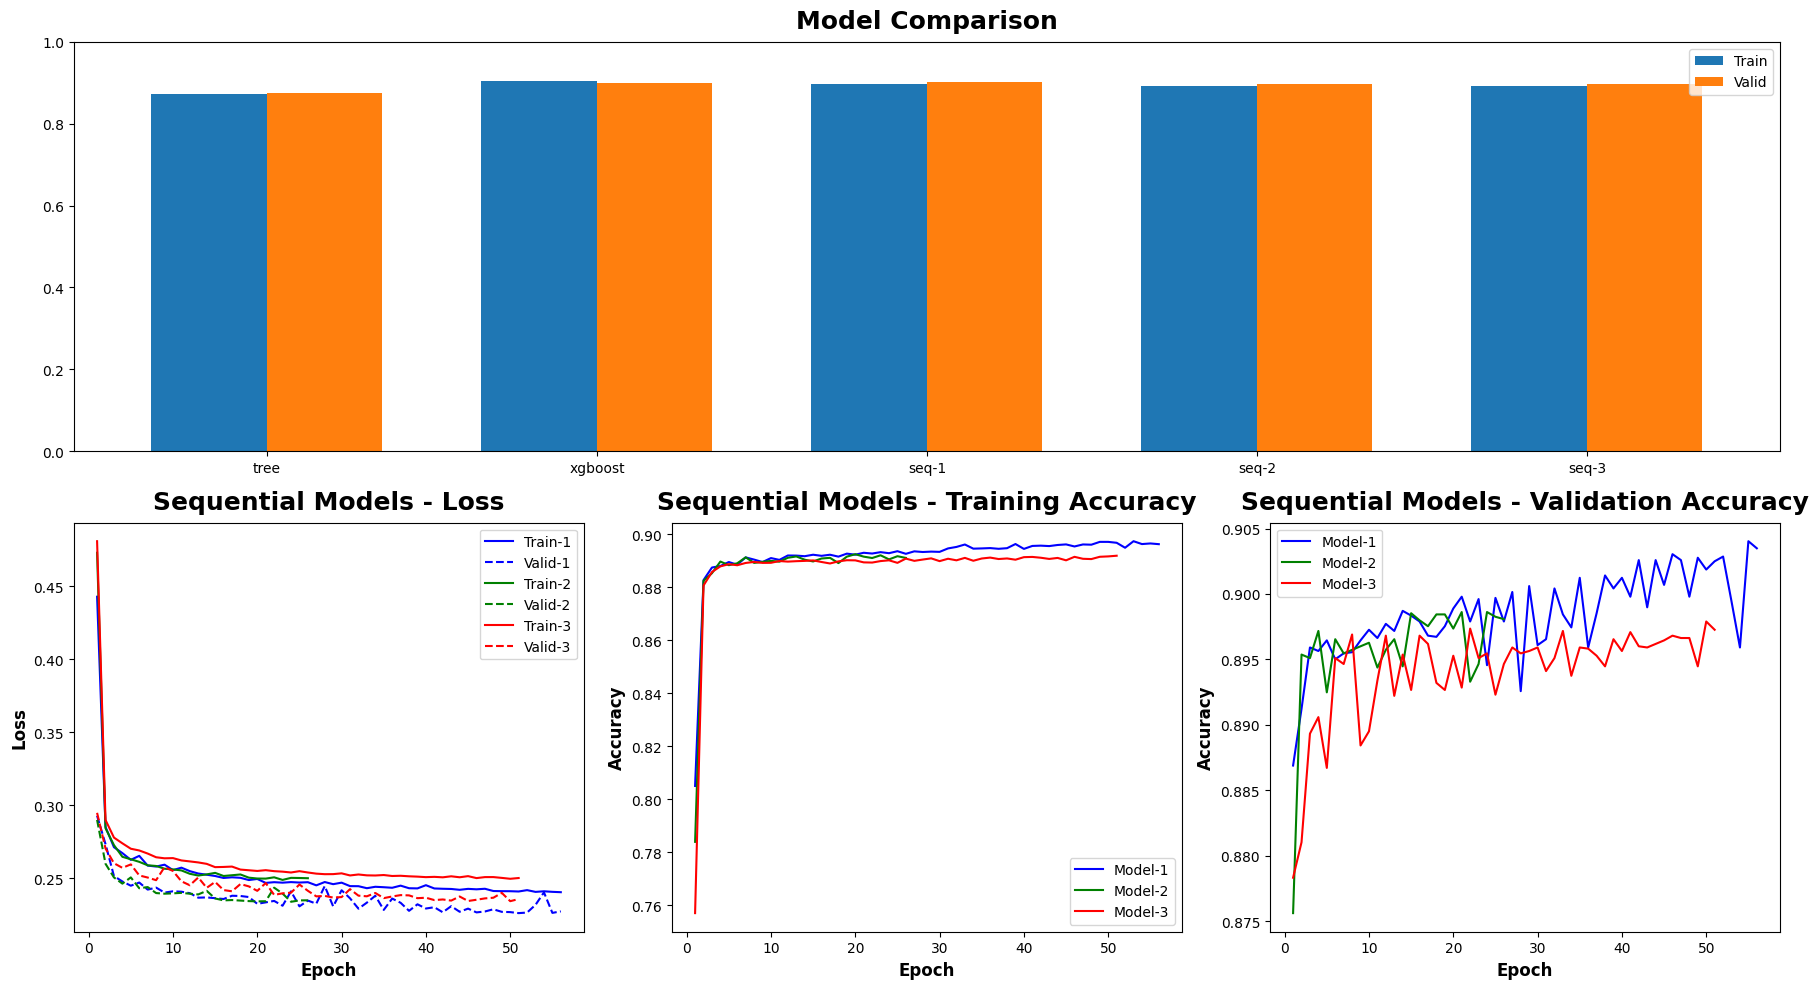

In [19]:
# Top model training
top_models = get_models(jungle_input_shape[0])
top_models, top_results, top_best_model_type, top_best_model, top_best_seq_key = train_models(
    top_X_train, top_X_valid, top_y_train, top_y_valid, top_models,
    epochs=100, batch_size=256
)

# Visualize results
fig = visualize_model_results(top_results, top_best_model_type, top_best_seq_key)

## Test 'Top' model

In [20]:
# Evaluate the best model on the test set
top_test_accuracy = evaluate_model(top_best_model, top_X_test, top_y_test, top_best_model_type)
print(f"Top model test accuracy: {top_test_accuracy:.4f}")

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step
Top model test accuracy: 0.9061


## Data fetching for 'Jungle' role

In [21]:
jungle_X_train, jungle_X_valid, jungle_X_test, jungle_y_train, jungle_y_valid, jungle_y_test = get_role_data(player_roles[1])

jungle_input_shape = [jungle_X_train.shape[1]]
print("Input shape: {}".format(jungle_input_shape))

Input shape: [10]


## 'Jungle' model training

c:\Users\arthu\source\AI_LAB_Maintenance\AI_LAB_MA1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\arthu\source\AI_LAB_Maintenance\AI_LAB_MA1\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\arthu\source\AI_LAB_Maintenance\AI_LAB_MA1\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:28:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Results:
  tree: train acc=0.8847, valid acc=0.8817
  xgboost: train acc=0.9150, valid acc=0.9090
  sequential models:
    model 1: train acc=0.9072, valid acc=0.9105
    model 2: train acc=0.9079, valid acc=0.9110
    model 3: train acc=0.9019, valid acc=0.9045
Best model: sequential - 2


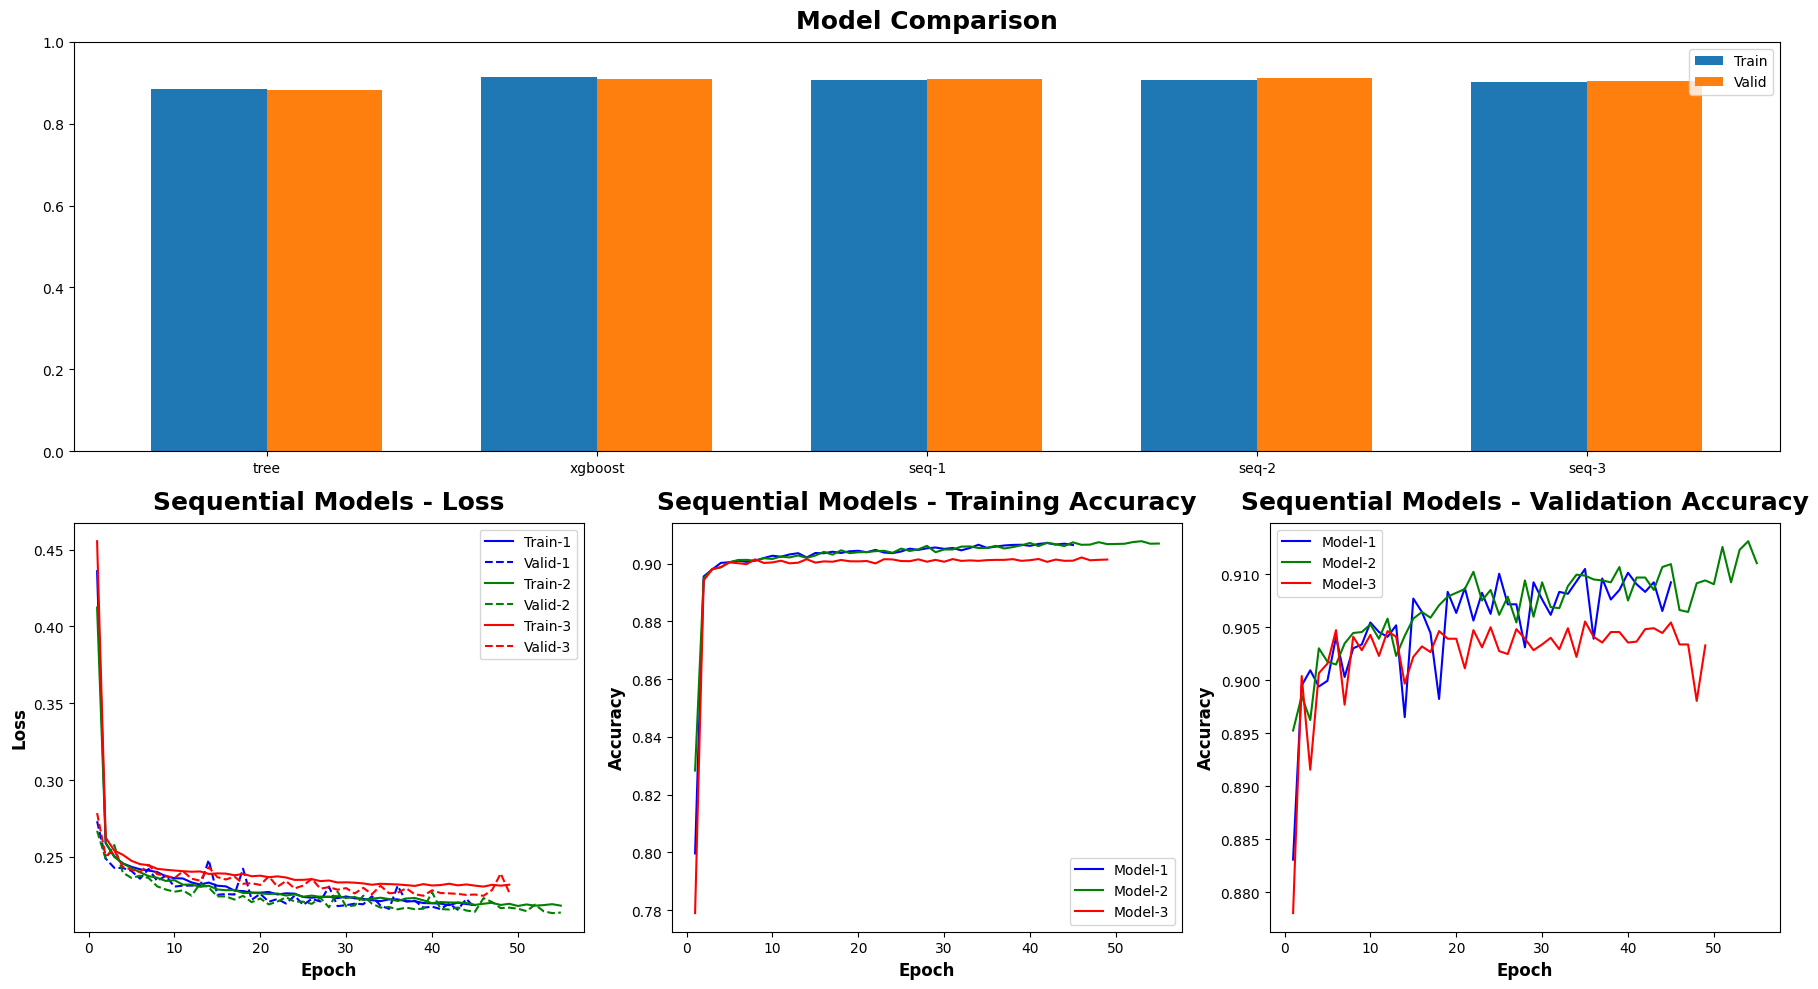

In [22]:
jungle_models = get_models(jungle_input_shape[0])
jungle_models, jungle_results, jungle_best_model_type, jungle_best_model, jungle_best_seq_key = train_models(
    jungle_X_train, jungle_X_valid, jungle_y_train, jungle_y_valid, jungle_models, 
    epochs=100, batch_size=256
)

# Visualize jungle results
fig = visualize_model_results(jungle_results, jungle_best_model_type, jungle_best_seq_key)

In [23]:
# Test data
jungle_test_accuracy = evaluate_model(jungle_best_model, jungle_X_test, jungle_y_test, jungle_best_model_type)
print(f"Jungle model test accuracy: {jungle_test_accuracy:.4f}")

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step
Jungle model test accuracy: 0.9080


## Data fetching for 'Middle' role

In [24]:
mid_X_train, mid_X_valid, mid_X_test, mid_y_train, mid_y_valid, mid_y_test = get_role_data(player_roles[2])

mid_input_shape = [mid_X_train.shape[1]]
print("Input shape: {}".format(mid_input_shape))

Input shape: [10]


## 'Middle' model training

c:\Users\arthu\source\AI_LAB_Maintenance\AI_LAB_MA1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\arthu\source\AI_LAB_Maintenance\AI_LAB_MA1\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\arthu\source\AI_LAB_Maintenance\AI_LAB_MA1\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:29:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Results:
  tree: train acc=0.8755, valid acc=0.8687
  xgboost: train acc=0.9143, valid acc=0.8996
  sequential models:
    model 1: train acc=0.9030, valid acc=0.8966
    model 2: train acc=0.9074, valid acc=0.8999
    model 3: train acc=0.9010, valid acc=0.8964
Best model: sequential - 2


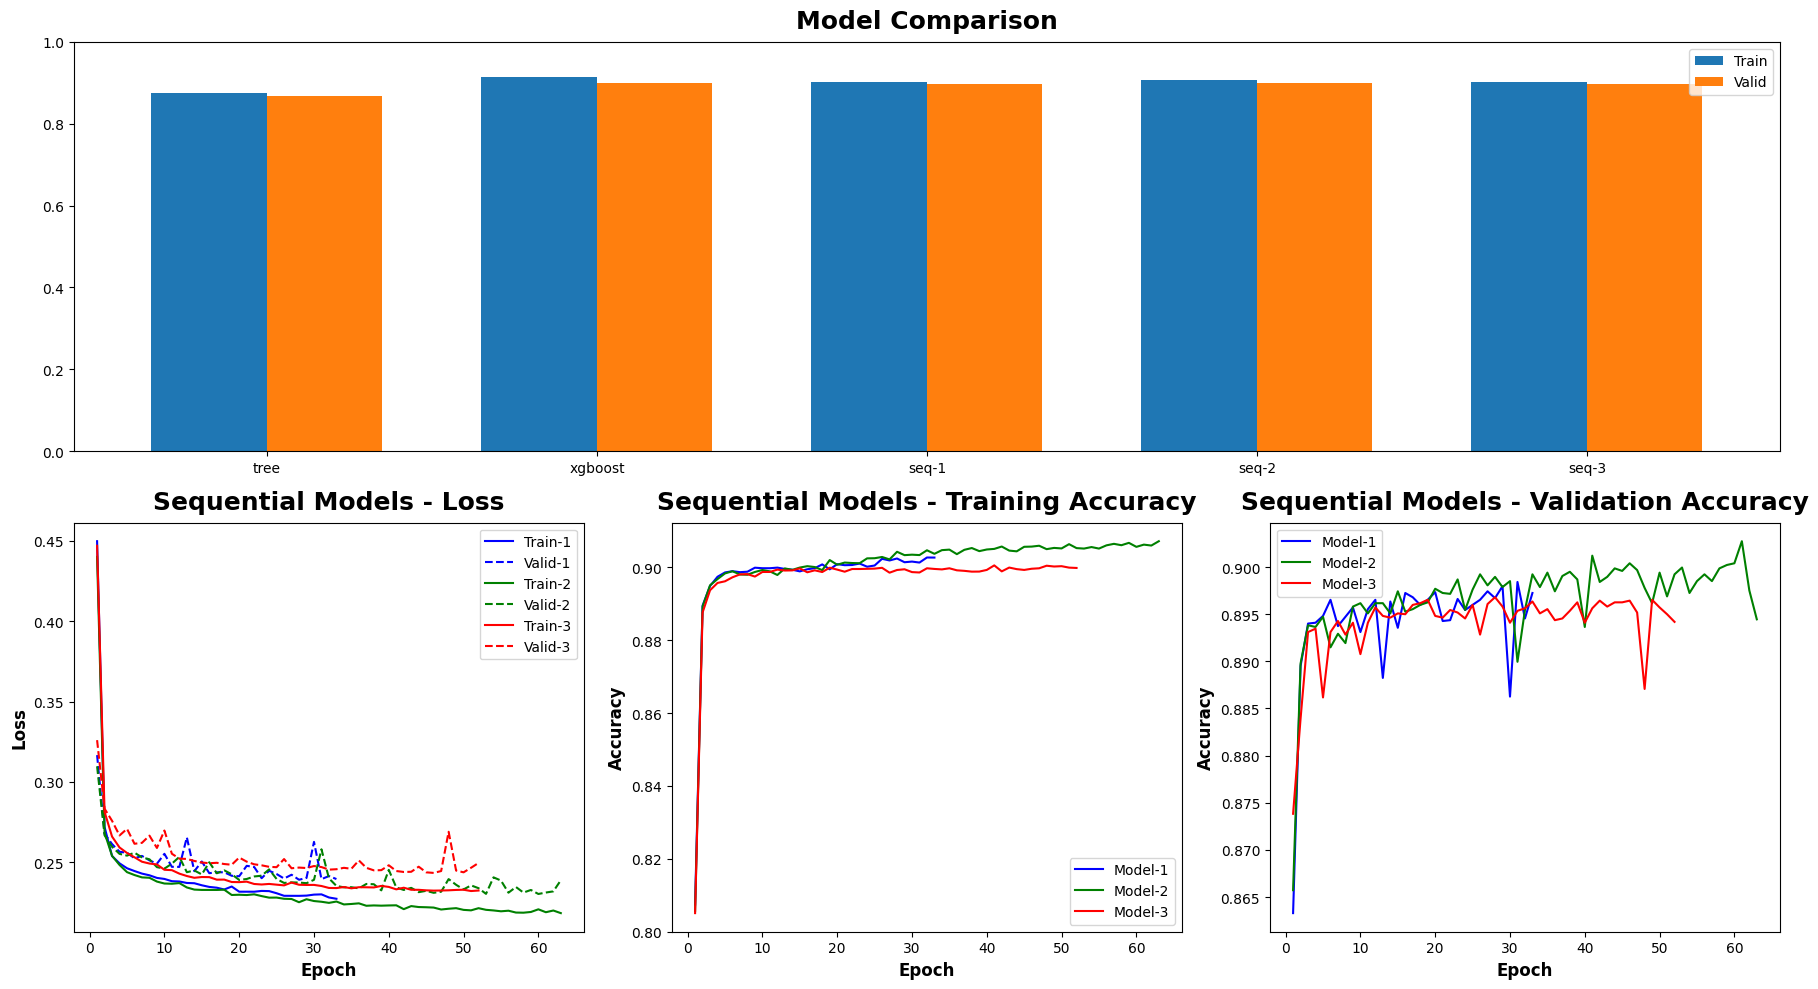

In [25]:
mid_models = get_models(mid_input_shape[0])
mid_models, mid_results, mid_best_model_type, mid_best_model, mid_best_seq_key = train_models(
    mid_X_train, mid_X_valid, mid_y_train, mid_y_valid, mid_models, 
    epochs=100, batch_size=256
)

# Visualize mid results
fig = visualize_model_results(mid_results, mid_best_model_type, mid_best_seq_key)

In [26]:
# Test data
mid_test_accuracy = evaluate_model(mid_best_model, mid_X_test, mid_y_test, mid_best_model_type)
print(f"Mid model test accuracy: {mid_test_accuracy:.4f}")

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step
Mid model test accuracy: 0.9061


## Data fetching for 'Support' role

In [27]:
sup_X_train, sup_X_valid, sup_X_test, sup_y_train, sup_y_valid, sup_y_test = get_role_data(player_roles[2])

sup_input_shape = [sup_X_train.shape[1]]
print("Input shape: {}".format(sup_input_shape))

Input shape: [10]


## 'Support' model training

c:\Users\arthu\source\AI_LAB_Maintenance\AI_LAB_MA1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\arthu\source\AI_LAB_Maintenance\AI_LAB_MA1\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\arthu\source\AI_LAB_Maintenance\AI_LAB_MA1\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:30:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Results:
  tree: train acc=0.8758, valid acc=0.8709
  xgboost: train acc=0.9137, valid acc=0.9016
  sequential models:
    model 1: train acc=0.9057, valid acc=0.9030
    model 2: train acc=0.9043, valid acc=0.9020
    model 3: train acc=0.8994, valid acc=0.8983
Best model: sequential - 1


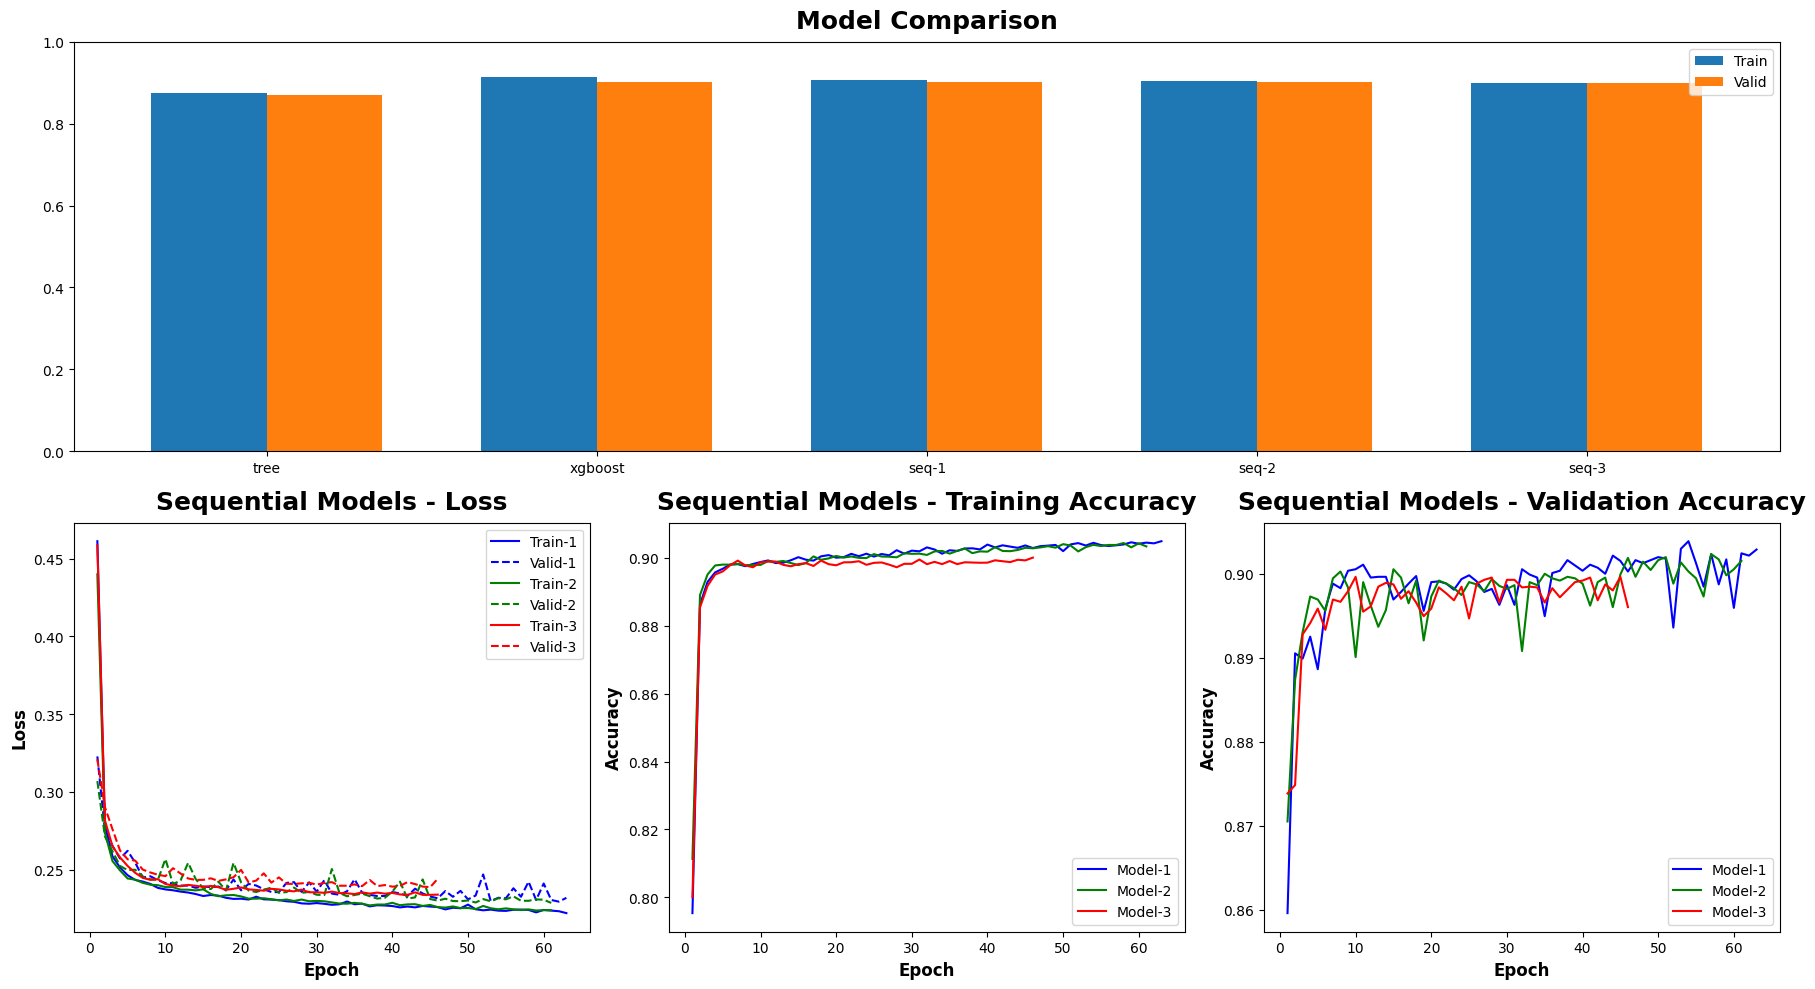

In [28]:
sup_models = get_models(sup_input_shape[0])
sup_models, sup_results, sup_best_model_type, sup_best_model, sup_best_seq_key = train_models(
    sup_X_train, sup_X_valid, sup_y_train, sup_y_valid, sup_models, 
    epochs=100, batch_size=256
)

# Visualize sup results
fig = visualize_model_results(sup_results, sup_best_model_type, sup_best_seq_key)

In [29]:
# Test data
sup_test_accuracy = evaluate_model(sup_best_model, sup_X_test, sup_y_test, sup_best_model_type)
print(f"Support model test accuracy: {sup_test_accuracy:.4f}")

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step
Support model test accuracy: 0.9097


## Data fetching for 'Bottom' role

In [30]:
bot_X_train, bot_X_valid, bot_X_test, bot_y_train, bot_y_valid, bot_y_test = get_role_data(player_roles[4])

bot_input_shape = [bot_X_train.shape[1]]
print("Input shape: {}".format(bot_input_shape))

Input shape: [10]


## 'Bottom' model training

c:\Users\arthu\source\AI_LAB_Maintenance\AI_LAB_MA1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\arthu\source\AI_LAB_Maintenance\AI_LAB_MA1\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\arthu\source\AI_LAB_Maintenance\AI_LAB_MA1\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:31:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Results:
  tree: train acc=0.8910, valid acc=0.8888
  xgboost: train acc=0.9266, valid acc=0.9177
  sequential models:
    model 1: train acc=0.9162, valid acc=0.9177
    model 2: train acc=0.9157, valid acc=0.9175
    model 3: train acc=0.9147, valid acc=0.9153
Best model: xgboost


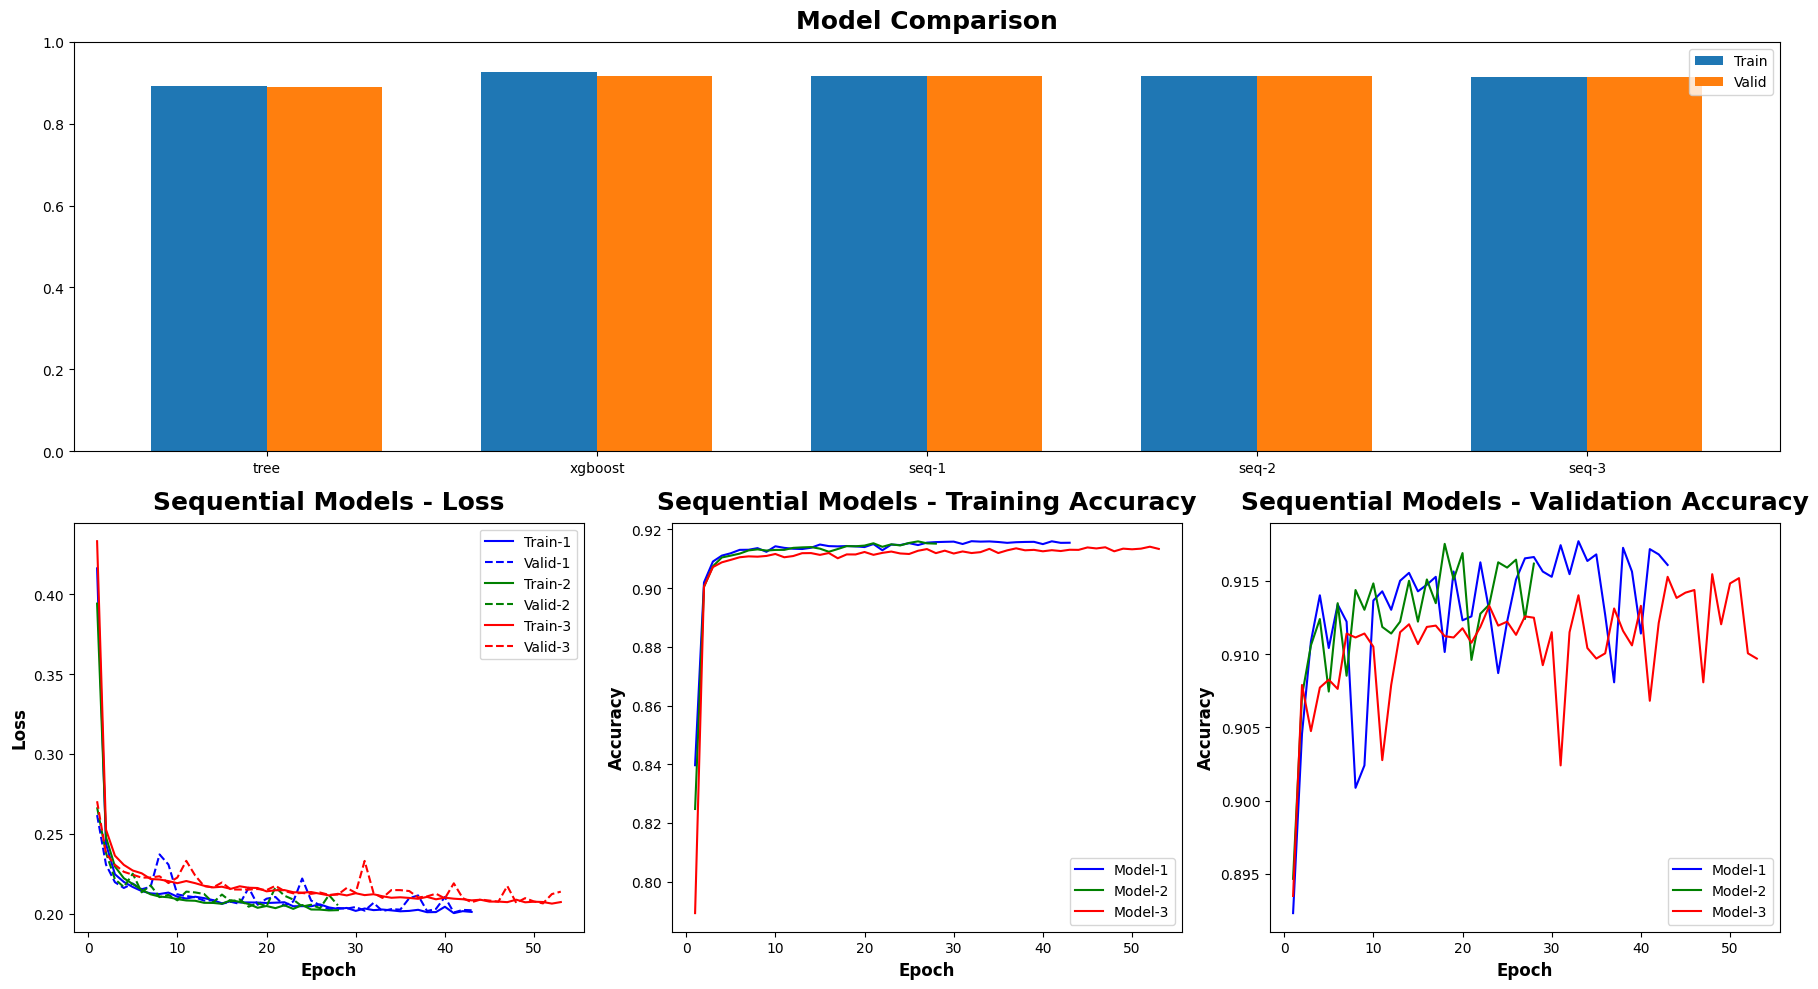

In [31]:
bot_models = get_models(bot_input_shape[0])
bot_models, bot_results, bot_best_model_type, bot_best_model, bot_best_seq_key = train_models(
    bot_X_train, bot_X_valid, bot_y_train, bot_y_valid, bot_models, 
    epochs=100, batch_size=256
)

# Visualize bot results
fig = visualize_model_results(bot_results, bot_best_model_type, bot_best_seq_key)

In [32]:
# Test data
bot_test_accuracy = evaluate_model(bot_best_model, bot_X_test, bot_y_test, bot_best_model_type)
print(f"Bot model test accuracy: {bot_test_accuracy:.4f}")

Bot model test accuracy: 0.9106


## Collect training and validation accuracies

,Role,Model Type,Train Accuracy,Valid Accuracy,Loss
0,Top,Sequential-1,0.897614,0.903040,0.227399
1,Jungle,Sequential-2,0.907881,0.910953,0.213808
2,Mid,Sequential-2,0.907415,0.899946,0.238856
3,Support,Sequential-1,0.905660,0.902987,0.231870
4,Bot,Xgboost,0.926632,0.917694,NaN


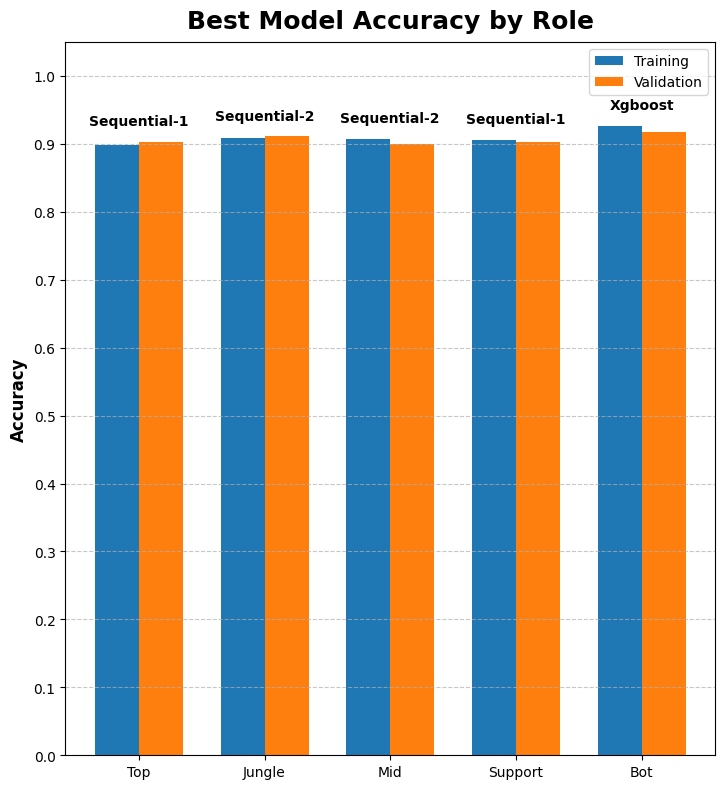

Top model loss: 0.2274 - Quality: EXCELLENT
  67.2% improvement over random guessing (0.693)
Jungle model loss: 0.2138 - Quality: EXCELLENT
  69.1% improvement over random guessing (0.693)
Mid model loss: 0.2389 - Quality: EXCELLENT
  65.5% improvement over random guessing (0.693)
Support model loss: 0.2319 - Quality: EXCELLENT
  66.5% improvement over random guessing (0.693)
Bot model has invalid loss value: nan


In [33]:
# Collect best model results for each role
role_results = {
    'Top': {'type': top_best_model_type, 'seq_key': top_best_seq_key, 'results': top_results},
    'Jungle': {'type': jungle_best_model_type, 'seq_key': jungle_best_seq_key, 'results': jungle_results},
    'Mid': {'type': mid_best_model_type, 'seq_key': mid_best_seq_key, 'results': mid_results},
    'Support': {'type': sup_best_model_type, 'seq_key': sup_best_seq_key, 'results': sup_results},
    'Bot': {'type': bot_best_model_type, 'seq_key': bot_best_seq_key, 'results': bot_results}
}

# Extract accuracy and loss values
accuracies = {'Role': [], 'Model Type': [], 'Train Accuracy': [], 'Valid Accuracy': [], 'Loss': []}

for role, data in role_results.items():
    model_type = data['type']
    results = data['results']
    
    # Handle different model types
    if model_type == 'sequential':
        seq_key = data['seq_key']
        train_acc = results['sequential']['train_accuracy'][seq_key]
        valid_acc = results['sequential']['valid_accuracy'][seq_key]
        
        # Get the final loss value from history
        history = results['sequential']['histories'][seq_key]
        final_loss = history.history['val_loss'][-1]
        
        model_display = f'Sequential-{seq_key}'
    else:
        train_acc = results[model_type]['train_accuracy']
        valid_acc = results[model_type]['valid_accuracy']
        final_loss = None  # Tree and XGBoost don't track loss the same way
        model_display = model_type.capitalize()
    
    accuracies['Role'].append(role)
    accuracies['Model Type'].append(model_display)
    accuracies['Train Accuracy'].append(train_acc)
    accuracies['Valid Accuracy'].append(valid_acc)
    accuracies['Loss'].append(final_loss)

# Create a DataFrame for better viewing
acc_df = pd.DataFrame(accuracies)
display(acc_df)

# Create visualization
plt.figure(figsize=(14, 8))

# Bar chart of accuracies by role
ax1 = plt.subplot(1, 2, 1)
roles = acc_df['Role']
x = np.arange(len(roles))
width = 0.35

train_bars = ax1.bar(x - width/2, acc_df['Train Accuracy'], width, label='Training')
valid_bars = ax1.bar(x + width/2, acc_df['Valid Accuracy'], width, label='Validation')

# Add model type labels above bars
for i, (model_type, train_acc, valid_acc) in enumerate(zip(acc_df['Model Type'], 
                                                          acc_df['Train Accuracy'], 
                                                          acc_df['Valid Accuracy'])):
    ax1.annotate(f"{model_type}", 
                xy=(i, max(train_acc, valid_acc) + 0.02),
                ha='center', va='bottom', 
                fontweight='bold')

ax1.set_ylabel('Accuracy')
ax1.set_title('Best Model Accuracy by Role')
ax1.set_xticks(x)
ax1.set_xticklabels(roles)
ax1.set_ylim(0, 1.05)
ax1.set_yticks(np.arange(0, 1.05, 0.1))
ax1.legend()

# Add grid for better readability
ax1.grid(True, linestyle='--', alpha=0.7, axis='y')

# Plot loss values for neural network models
seq_roles = [role for role, loss in zip(roles, acc_df['Loss']) if loss is not None]
seq_losses = [loss for loss in acc_df['Loss'] if loss is not None]
seq_accuracies = [acc for role, acc in zip(roles, acc_df['Valid Accuracy']) 
                 if role in seq_roles]


plt.tight_layout()
plt.show()

# Evaluation of loss values
for role in seq_roles:
    loss = acc_df.loc[acc_df['Role'] == role, 'Loss'].values[0]
    # Check if loss is valid before evaluation
    if loss is not None and np.isfinite(loss):
        quality = "EXCELLENT" if loss < 0.3 else "GOOD" if loss < 0.5 else "ACCEPTABLE" if loss < 0.693 else "POOR"
        improvement = round((0.693 - loss) / 0.693 * 100, 1)  # Improvement over random guessing
        
        print(f"{role} model loss: {loss:.4f} - Quality: {quality}")
        print(f"  {improvement}% improvement over random guessing (0.693)")
    elif loss is not None:
        print(f"{role} model has invalid loss value: {loss}")

## Save models

In [35]:
import os
import joblib
def save_one_model(best_model, best_model_type, model_name, model_path):
    os.makedirs(model_path, exist_ok=True)
  
    # Save model based on its type
    if best_model_type == "xgboost":
        best_model.save_model('role_models/' + model_name + '.json')
    elif best_model_type == "tree":
        joblib.dump(best_model, 'role_models/' + model_name + '.joblib')
    else:  # Sequential model
        best_model.save('role_models/' + model_name + '.keras')
  
def save_all_models():
    os.makedirs('role_models', exist_ok=True)
    save_one_model(top_best_model, top_best_model_type, 'top_model', 'role_models')
    save_one_model(jungle_best_model, jungle_best_model_type, 'jungle_model', 'role_models')
    save_one_model(mid_best_model, mid_best_model_type, 'mid_model', 'role_models')
    save_one_model(sup_best_model, sup_best_model_type, 'sup_model', 'role_models')
    save_one_model(bot_best_model, bot_best_model_type, 'bot_model', 'role_models')
  
def save_tools():
    os.makedirs('tools', exist_ok=True)
  
    joblib.dump(win_loose_preprocessor, 'tools/win_loose_preprocessor.pkl')
  
save_all_models()
save_tools()